# Intro

The functions described in this notebook make extensive use of LOWESS (also known as LOESS) curve-smoothing. There are many implementations of LOESS fitting in python, but these functions use the lowess() function described here:
https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

LOESS curve-smoothing generates new data points following the general trend of the data. This is done through local least squares fitting at each data point, and a 'fraction' input variable controls how much of the total dataset is considered when making these local fits. A lower 'fraction' captures more local behaviour.

# Setup

Make sure to install pylenm from https://pypi.org/project/pylenm/ by running `pip install pylenm` in your environment terminal. Once completed, you should be able to import the package. Note: to update to the latest version of pylenm run: `pip install pylenm --upgrade`

Set up our pylenm2 datamodule by importing the example data:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pylenm2.data import filters
from pylenm2 import PylenmDataModule

In [2]:
# url_1 = 'https://raw.githubusercontent.com/ALTEMIS-DOE/pylenm/master/notebooks/data/FASB_Data_thru_3Q2015_Reduced_Demo.csv'
# url_2 = 'https://github.com/ALTEMIS-DOE/pylenm/blob/master/notebooks/data/FASB%20Well%20Construction%20Info.xlsx?raw=true'

# since these functions are made for pylenm_general.py, we need a version of the example data with the word "well" replaced with "station"
# "well" versions:
# url_1 = './data/FASB_Data_thru_3Q2015_Reduced_Demo.csv'
# url_2 = './data/FASB Well Construction Info.xlsx'  
# "station" versions:
# url_1 = './data/FASB_Data_thru_3Q2015_Reduced_Demo_general.csv'
# url_2 = './data/FASB_Well_Construction_Info_general.xlsx'

url_1 = "https://raw.githubusercontent.com/ALTEMIS-DOE/pylenm/refs/heads/satyarth/notebooks2/data/FASB_Data_thru_3Q2015_Reduced_Demo_general.csv"
url_2 = "https://github.com/ALTEMIS-DOE/pylenm/raw/refs/heads/satyarth/notebooks2/data/FASB_Well_Construction_Info_general.xlsx?raw=true"

concentration_data = pd.read_csv(url_1, dtype={15: str, 22: str, 23: str})
construction_data = pd.read_excel(url_2)

In [3]:
pylenm2_dm = PylenmDataModule(
    data=concentration_data,    # Save concentration data
    construction_data=construction_data,    # Save construction data
) # Save concentration data
# pylenm2_dm.set_construction_data(construction_data) # Save construction data

Successfully imported the data!

Successfully imported the construction data!



# Outlier Removal

The first function introduced in this notebook is simple: `remove_outliers_lowess()` detects outliers in time series data using a LOWESS fit, and sets them to `np.nan`. Below is an example using water table data from monitoring station FSP-12A.

**NOTE:** the format of `wt_data` below is the *required format* for inputs to `remove_outliers_lowess()`: a pd.Series (or single-column pd.DataFrame) of measurements, indexed by datetime (or indexed by strings in a valid format to be transformed into datetimes via `pd.to_datetime()`).

In [4]:
# get data from monitoring station FSP-12A
stn = 'FSP-12A'
ana = 'DEPTH_TO_WATER'

wt_data = pylenm2_dm.data[
    (pylenm2_dm.data.STATION_ID == stn) &
    (pylenm2_dm.data.ANALYTE_NAME == ana)
].set_index('COLLECTION_DATE').RESULT
wt_data.index = pd.to_datetime(wt_data.index)
wt_data

COLLECTION_DATE
2006-03-20    5.23
2006-02-21    5.20
2006-01-24    5.00
2005-01-05    5.50
2005-02-22    5.40
              ... 
2015-03-04    4.20
2015-03-23    4.20
2015-06-09    4.23
2015-06-15    4.27
2015-09-08    4.43
Name: RESULT, Length: 279, dtype: float64

2024-11-04 21:02:33,574 [ERROR] preprocess.py: line 96: cannot reindex on an axis with duplicate labels


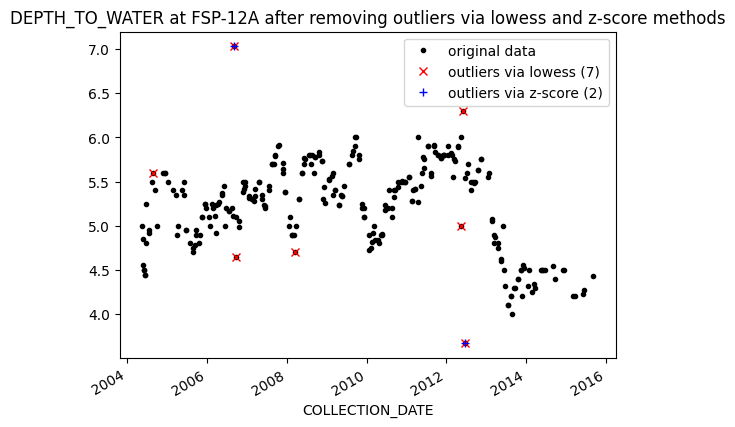

In [5]:
from pylenm2.stats import preprocess

import importlib
importlib.reload(preprocess)

## using LOWESS fitting to remove outliers:

# set outliers to np.nan
wt_data_xOutliers = preprocess.remove_outliers_lowess(wt_data)

# identify outlier locations
outliers_loc = wt_data_xOutliers.compare(wt_data).index  # dates at which outliers occurred have had their values set to np.nan
outliers = wt_data.loc[outliers_loc]
num_outliers =  outliers.size

## removing outliers based on their z-score:
wt_data_xOutliers_zScore = preprocess.remove_outliers(wt_data, z_threshold=3)
outliers_loc_zScore = wt_data[~wt_data.isin(wt_data_xOutliers_zScore)].index
outliers_zScore = wt_data.loc[outliers_loc_zScore]
num_outliers_zScore =  outliers_zScore.size

wt_data.plot(style='.', label='original data', color='black')
outliers.plot(style='x', label=f'outliers via lowess ({num_outliers})', color='red')
outliers_zScore.plot(style='+', label=f'outliers via z-score ({num_outliers_zScore})', color='blue')
plt.legend()
plt.title(f'{ana} at {stn} after removing outliers via lowess and z-score methods')
plt.show()

For decreasing data like `DEPTH_TO_WATER` at FSP-12A, `remove_outliers_lowess()` identifies more points that deviate from the overall trend. Decreasing data like this doesn't occur very often at SRS, but it can occur more often at other contaminated sites, so this function is a key part of generalizing pylenm to other sites.

The way this function works is that it makes a LOWESS fit to the data, then calculates the difference between the data and the LOWESS fit (observation - fit). An "outlier" is defined as a data point outside a user-determined number of standard deviations of (observation - fit) (default is 2.2 standard deviations). The user can also tweak the LOWESS fit itself using the `lowess_frac` parameter; a smaller `lowess_frac` tends to capture more "local behaviour" in the fit. this parameter is described in more detail in the introduction.

You can see what's happening behind the scenes by setting `lowess_frac=True`:

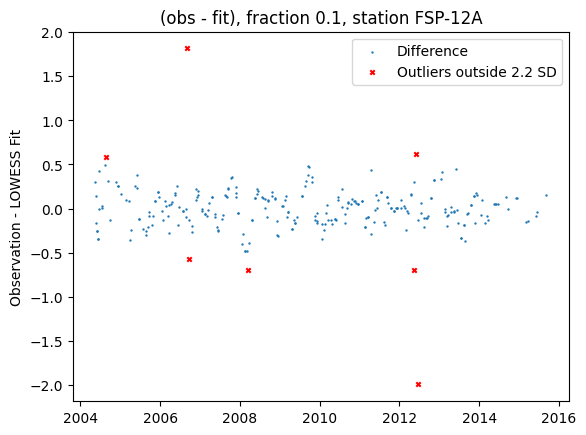

In [6]:
lowess_frac = 0.1
std_thresh = 2.2
wt_data_xOutliers, difference = preprocess.remove_outliers_lowess(wt_data, lowess_frac=lowess_frac, std_thresh=std_thresh, return_difference=True)

plt.scatter(difference.index, difference, s=0.5, label='Difference')
plt.scatter(difference[outliers_loc].index, difference[outliers_loc], s=10, marker='x', color='red', label=f'Outliers outside {std_thresh} SD')
plt.title("(obs - fit), fraction "+ str(lowess_frac) + ", station "+ str(stn))
plt.ylabel('Observation - LOWESS Fit')
plt.legend()
plt.show()

# Plotting Data

If we want to see the water table over time at some station, for example FBI 14D, then `plot_data_lowess()` will remove outliers (via a call to `remove_outliers_lowess()`) and plot the time series data alongside a smoothed LOWESS fit.

This function is similar to the default plot_data(), except it introduces LOWESS time-series outlier removal and uses LOWESS instead of Supersmoother.

If we want to see a plot of difference=observation-LOWESS fit, which was used to define and remove outliers, we can toggle that with `show_difference=True`

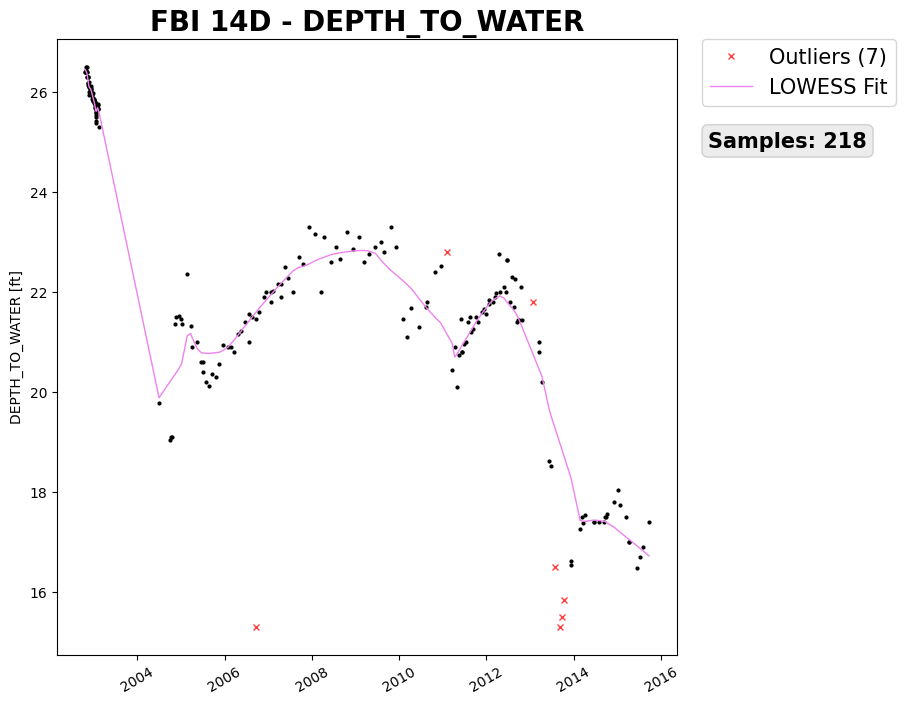

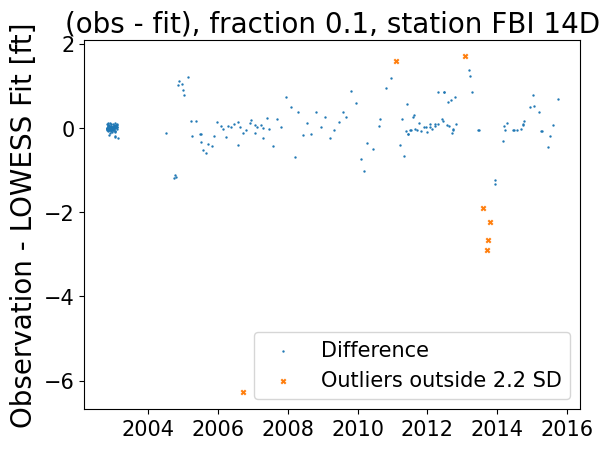

In [7]:
from pylenm2.visualization import plots

plots.plot_data_lowess(
    data_pylenm_dm=pylenm2_dm,
    station_name='FBI 14D', 
    analyte_name='DEPTH_TO_WATER', 
    show_difference=True,
)

If we find that the LOWESS fit smooths the data a bit too much, we can use `plot_data_rollAvg()` instead. This function again removes outliers via LOWESS, and then takes a time average (default 1 week) centred around each data point and assigns the result to that point. This rolling time average is then plotted alongside the original data. The user can set the averaging period using `window='1W'`; where the valid inputs (ex. `'1W'`, `'4W'`, `'3D'`) are listed by pandas here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

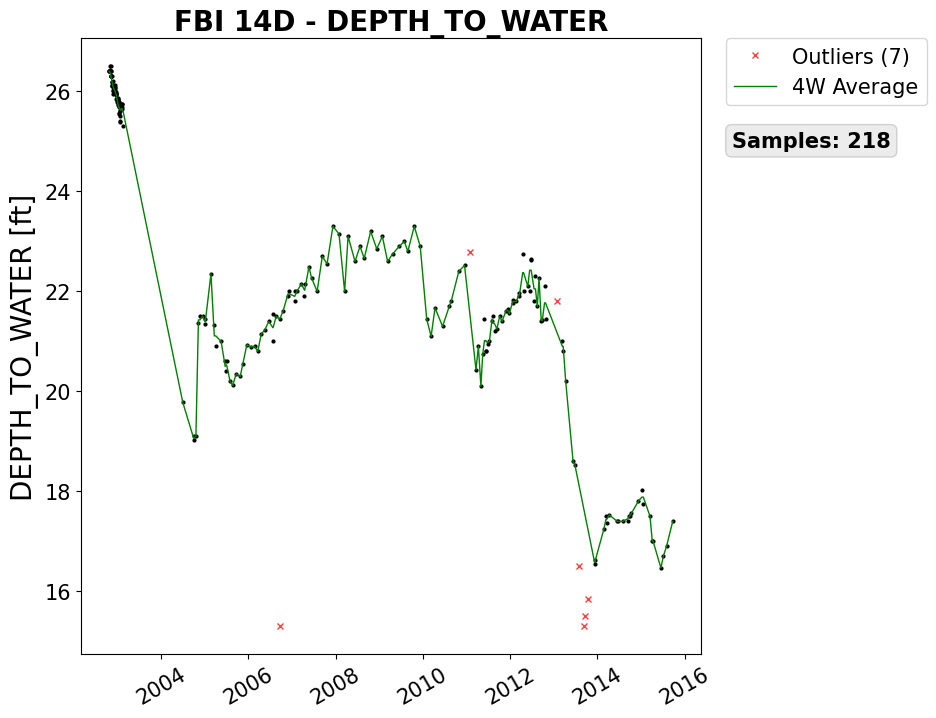

In [8]:
plots.plot_data_rollAvg(
    data_pylenm_dm=pylenm2_dm,
    station_name='FBI 14D', 
    analyte_name='DEPTH_TO_WATER', 
    window='4W',
)
# pylenm_df.plot_data_rollAvg(station_name='FBI 14D', analyte_name='DEPTH_TO_WATER', window='8W')  # wider windows look smoother

Both of these functions are very customizable: the user can toggle on/off various settings including returning the data used in plotting, removing outliers, zooming into the data after outliers have been removed (some outliers are really far from the original data, which distorts the plot by auto-zooming way out), and more! The user can also customize the LOWESS outlier removal parameters (`std_thresh` and `lowess_frac`).

A full description of all of the inputs can be found in the source code, but feel free to play around with them on a new station below!

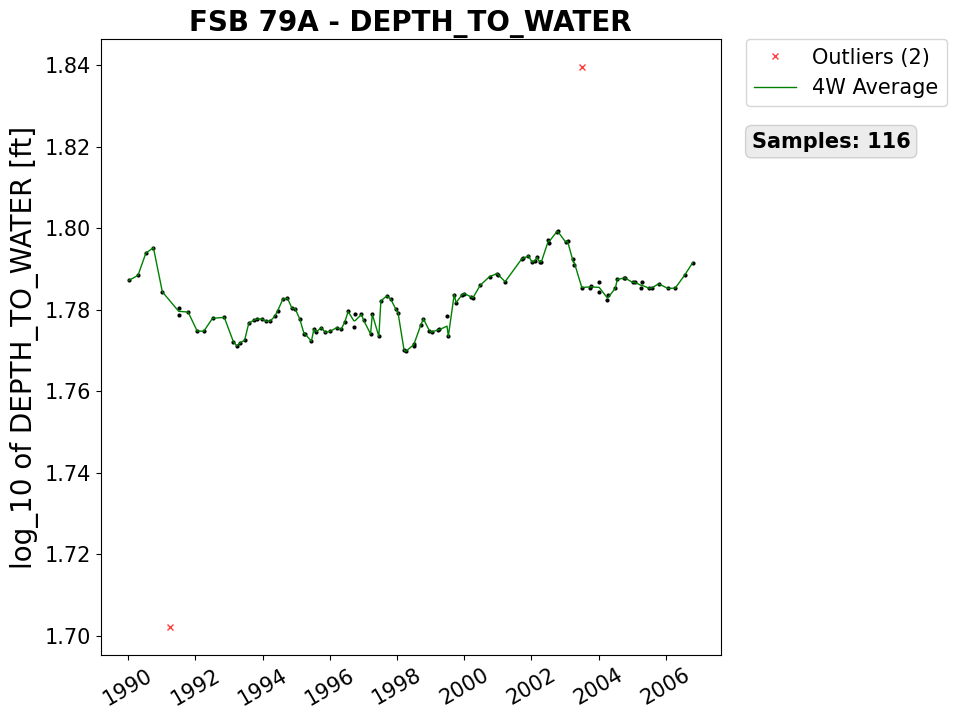

In [9]:
data_xOutliers, data_rollAvg, data_outliers = plots.plot_data_rollAvg(
    data_pylenm_dm=pylenm2_dm,
    station_name='FSB 79A', 
    analyte_name='DEPTH_TO_WATER', 
    window='4W', 
    # rm_outliers=False, 
    std_thresh=2, 
    lowess_frac=0.1, 
    # show_difference=True, 
    x_label=None, 
    y_label=None, 
    year_interval=2, 
    log_transform=True, 
    # y_zoom=True, 
    return_data=True, 
    # save=True, 
    save_dir='plot_data_lowess', 
    # plot_inline=False, 
    save_as_pdf=True,
)

# Time Averaging and Aligning All Stations

The new `time_average_all_stations()` function aligns all stations' time series data (for one analyte) such that they all have measurements at the same dates. The user specifies a time period, ex. 4 weeks `'4W'`, and the function returns a Pandas DataFrame with stations as columns and dates as index, with the dates separated by the specified time period. At each station at each time, the DataFrame will be populated by the average value for that station from this time to the next (ex. a 4-week average). If the station has no data in that 4-week period, that entry will be `np.nan`.

This function can be thought of as an alternative to `interpolate_stations_by_analyte()` (formerly `interpolate_wells_by_analyte()`): the user specifies an analyte, and the function returns a Pandas DataFrame with stations as columns and times as index. However, `time_average_all_stations()` differs in a few notable ways:
- it uses `remove_outliers_lowess()` for time series outlier removal, instead of dropping based on z-score (ie distance from the mean of the data)
- it doesn't interpolate between data points, as this can introduce artifacts in less-predictable time series data
- it doesn't replace `np.nan` values with the average station value

In [10]:
from pylenm2.data import transformation

time_period = '8W'
wt_avg = transformation.time_average_all_stations(
    data_pylenm_dm=pylenm2_dm,
    analyte='DEPTH_TO_WATER', 
    period=time_period,
)
wt_avg

/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/pylenm_env/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWar

,FBI 14D,FBI 15D,FBI 17D,FEX 4,FIB 1,FIB 8,FM-2BD,FM-A7U,FMC-002F,FMC-002H,...,FSP 2A,FSP 2B,FSP 47A,FSP-072A,FSP-072B,FSP-12A,FSP204A,FSP226A,FSP249A,FSP249B
1989-11-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-01,17.166667,14.245,24.03,26.2,22.24,19.6,NaN,NaN,NaN,NaN,...,6.40,6.02,4.82,3.65,2.80,4.20,4.12,3.4,2.86,2.50
2015-04-26,16.470000,14.770,24.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.70,6.40,5.30,4.10,3.22,4.25,4.72,4.2,2.92,2.80
2015-06-21,16.800000,15.000,24.60,26.4,21.50,19.3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.43,3.60,NaN,NaN,NaN,NaN,NaN
2015-08-16,17.400000,15.400,25.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.16,7.50,NaN,4.33,3.45,4.43,5.70,NaN,3.70,3.34


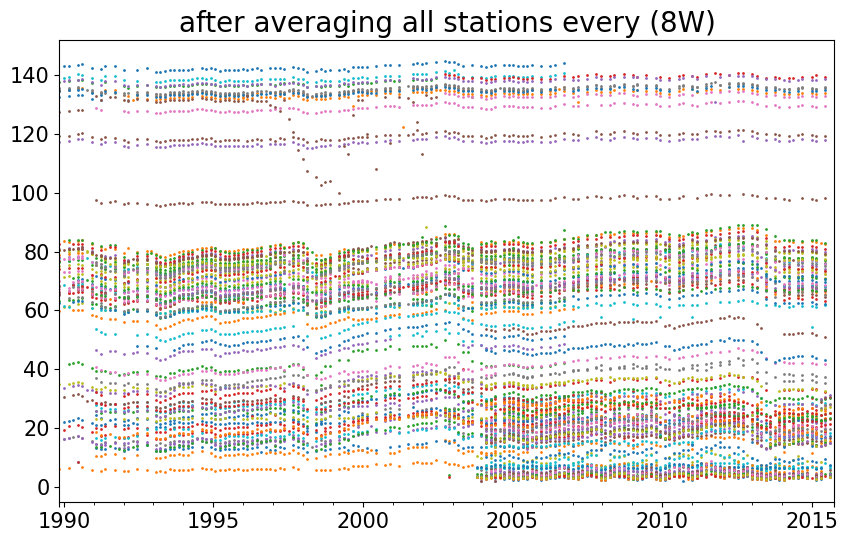

In [11]:
wt_avg.plot(style='.', ms=2, figsize=(10,6), title=f'after averaging all stations every ({time_period})', legend=False)
plt.show()

This function is particularly useful if you want to spatially interpolate between stations over time, because it gives all stations measurements at the same timesteps. Otherwise, potentially every station measures at different dates and times, making it difficult to define a single "timestep" at which to spatially interpolate.

However, if you want to use this function to interpolate via machine learning (ML), ML models typically do not understand `np.nan`, so you will need to drop all stations with NaN values at each timestep (or fill those nan values somehow). Below is an example of how to drop all stations with `np.nan` values to make an input appropriate for a Gaussian Process model as described here: https://fvgp.readthedocs.io/en/latest/api/GP.html

In [12]:
# get data for random timestep in wt_avg
random_timestep = pd.to_datetime('2015-03-01')
wt_avg_at_timestep = wt_avg.loc[random_timestep]

# get longitude/latitude for all stations in wt_avg (need location info to interpolate spatially)
station_lonlat = []
for station in wt_avg_at_timestep.index:
    if station in pylenm2_dm.construction_data.index.to_numpy():  # make sure this station exists in construction data
        lon = np.nanmean(pylenm2_dm.construction_data['LONGITUDE'][station])  # need to average because sometimes there are multiple entries
        lat = np.nanmean(pylenm2_dm.construction_data['LATITUDE'][station])
        if np.isnan(lon)==False and np.isnan(lat)==False:  # make sure station coordinates are not NaN
            station_lonlat.append([lon,lat])
station_lonlat_arr = np.array(station_lonlat)

# build ML input as an array X with shape (wt_avg_at_timestep.size, 3), then drop stations with np.nan data at this timestep
X_raw = np.array([station_lonlat_arr[:,0], station_lonlat_arr[:,1], wt_avg_at_timestep.to_numpy()]).T
X_nan = ~np.isnan(X_raw).any(axis=1)  # ML doesn't understand NaN, so need to identify rows of X (ie stations) with NaN values and remove those rows/stations
X = X_raw[X_nan]
print('Before dropping stations with np.nan:\n', X_raw, '\n')
print('After dropping stations with np.nan:\n', X)

Before dropping stations with np.nan:
 [[-81.6774153   33.27162418  17.16666667]
 [-81.67738325  33.2709165   14.245     ]
 [-81.67801569  33.27081556  24.03      ]
 [-81.67978285  33.27036953  26.2       ]
 [-81.67845571  33.27096946  22.24      ]
 [-81.67817112  33.27133411  19.6       ]
 [-81.67353774  33.27100088          nan]
 [-81.6863021   33.26234403          nan]
 [-81.67906676  33.2665425           nan]
 [-81.66825811  33.27281534          nan]
 [-81.67844657  33.2706489           nan]
 [-81.68003614  33.2702203   27.34      ]
 [-81.6800733   33.27019059  23.        ]
 [-81.67690287  33.27168575  20.2       ]
 [-81.67988081  33.26946969  21.79      ]
 [-81.67988537  33.26943814  13.89      ]
 [-81.68218193  33.26894429  19.9       ]
 [-81.6813115   33.26855628   2.885     ]
 [-81.67971739  33.26779226   6.29      ]
 [-81.67878775  33.27003888   6.2       ]
 [-81.67780875  33.26898915   2.4       ]
 [-81.67780875  33.26898915   2.6       ]
 [-81.6767944   33.26977849   4.1    